<a href="https://colab.research.google.com/github/mgozon/DLG-UROP/blob/main/Batch_DLG_Iris_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch-DLG - Iris Dataset
This notebook modifies the code in [Deep Leakage from Gradients](https://gist.github.com/Lyken17/91b81526a8245a028d4f85ccc9191884) to work with the Iris Dataset. In addition, it explores whether it is possible to repeat the same procedure on the batch input gradient.

In [99]:
# setting up libraries and device
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
torch.manual_seed(100) # for generating the same random weights

# for testing
from random import randint
from random import shuffle
from itertools import permutations
from scipy.optimize import linear_sum_assignment
import math

from sklearn.datasets import load_iris
dst = load_iris()

print(torch.__version__)
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
print("Running on %s" % device)

1.12.1+cu113
Running on cpu


In [100]:
# auxiliary functions for NN - conver to onehot and loss function
def label_to_onehot(target, num_classes = 3):
    target = torch.unsqueeze(target, 1)
    onehot_target = torch.zeros(target.size(0), num_classes, device=target.device)
    onehot_target.scatter_(1, target, 1)
    return onehot_target

def cross_entropy_for_onehot(pred, target):
    return torch.mean(torch.sum(- target * F.log_softmax(pred, dim=-1), 1))

In [111]:
# a random fully connected neural network with random weights and biases
def weights_init(m):
    if hasattr(m, "weight"):
        m.weight.data.uniform_(-0.5, 0.5)
    if hasattr(m, "bias"):
        m.bias.data.uniform_(-0.5, 0.5)
    
class FcNet(nn.Module):
    def __init__(self):
        super(FcNet, self).__init__()
        act = nn.Sigmoid
        self.body = nn.Sequential(
            nn.Linear(4, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 100),
            act(),
            nn.Linear(100, 3),
            act(),
        )
        
    def forward(self, x):
        out = self.body(x)
        out = out.view(out.size(0), -1)
        return out
    
net = FcNet().to(device)
    
net.apply(weights_init)
criterion = cross_entropy_for_onehot

In [112]:
# optionally train NN to see if it makes a difference
# TODO - consider partitioning dataset into a train and test portion
def train_net_LBFGS():
    epochs = 150
    batch_size = 32
    optimizer = torch.optim.LBFGS(net.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda epoch: 0.99)

    for epoch in range(epochs):
        #TODO - concatenate dst.data and dst.target and use dataloader to sample random mini batches
        gt_data = torch.tensor(dst.data).to(device)
        gt_label = torch.tensor(dst.target).to(device)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)
        #print('lbfgs: ', gt_data, gt_onehot_label)
        
        def closure():
            optimizer.zero_grad()
            output = net(gt_data.float())
            loss = criterion(output, gt_onehot_label)
            loss.backward()
            #print('closure loss: ', criterion(output, gt_onehot_label))
            #print(f'output: {output}, onehot_label: {gt_onehot_label}')
            print('loss: ', loss)
            return loss
      
        optimizer.step(closure)
        scheduler.step()

def train_net_Adam():
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    epochs = 100
    for i in range(epochs): # TODO - add random minibatches using dataloader
        optimizer.zero_grad()

        for input, target in zip(dst.data, dst.target):
            gt_data = torch.tensor(input).to(device)
            gt_data = gt_data.view(1, *gt_data.size())
            gt_label = torch.tensor(target).to(device)
            gt_label = gt_label.view(1)
            gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

            
            output = net(gt_data.float())
            print('adam: ', output.tolist(), gt_onehot_label.tolist())
            loss = criterion(output, gt_onehot_label)
            loss.backward()
            
            print('current loss: ', loss)
        
        optimizer.step()

def test_net():
    for input, target in zip(dst.data, dst.target):
        gt_data = torch.tensor(input).to(device)
        pred = net(gt_data.float())
        #print('input, target, pred: ', input, target, pred)
        pred = pred.view(-1)
        print(f'data: {gt_data.tolist()}, pred: {torch.argmax(pred).item()}, label: {target}')

# randomize dataset
# dst_length = dst.data.shape[0]
# perm = list(range(dst_length))
# shuffle(perm)

train_net_LBFGS()
test_net()

loss:  tensor(1.1379, grad_fn=<MeanBackward0>)
loss:  tensor(1.1379, grad_fn=<MeanBackward0>)
loss:  tensor(1.1378, grad_fn=<MeanBackward0>)
loss:  tensor(1.1338, grad_fn=<MeanBackward0>)
loss:  tensor(1.1328, grad_fn=<MeanBackward0>)
loss:  tensor(1.1323, grad_fn=<MeanBackward0>)
loss:  tensor(1.1318, grad_fn=<MeanBackward0>)
loss:  tensor(1.1312, grad_fn=<MeanBackward0>)
loss:  tensor(1.1306, grad_fn=<MeanBackward0>)
loss:  tensor(1.1299, grad_fn=<MeanBackward0>)
loss:  tensor(1.1291, grad_fn=<MeanBackward0>)
loss:  tensor(1.1283, grad_fn=<MeanBackward0>)
loss:  tensor(1.1275, grad_fn=<MeanBackward0>)
loss:  tensor(1.1266, grad_fn=<MeanBackward0>)
loss:  tensor(1.1258, grad_fn=<MeanBackward0>)
loss:  tensor(1.1249, grad_fn=<MeanBackward0>)
loss:  tensor(1.1242, grad_fn=<MeanBackward0>)
loss:  tensor(1.1234, grad_fn=<MeanBackward0>)
loss:  tensor(1.1227, grad_fn=<MeanBackward0>)
loss:  tensor(1.1221, grad_fn=<MeanBackward0>)
loss:  tensor(1.1215, grad_fn=<MeanBackward0>)
loss:  tensor

In [37]:
# process input flowers and compute gradient of batch
def batch_grad(flower_indices, verbose = 0):
    n = len(flower_indices)

    gt_dataset = []
    gt_labels = []
    for flower_index in flower_indices:
        gt_data = torch.tensor(dst.data[flower_index, :]).to(device)
        gt_data = gt_data.view(1, *gt_data.size())
        gt_dataset.append(gt_data)
        gt_label = torch.tensor(dst.target[flower_index]).to(device)
        gt_label = gt_label.view(1)
        gt_labels.append(gt_label)
        gt_onehot_label = label_to_onehot(gt_label, num_classes=3)

        # print out (data, label) and verify onehot
        if (verbose):
            print(f"gt_data: {gt_data}")
            print(f"gt_label: {gt_label}")
            print(f"gt_onehot_label: {gt_onehot_label}")
            print(f"flower {flower_index} has label (gt, onehot) = ({gt_label.item()}, {torch.argmax(gt_onehot_label, dim=-1).item()})")

        # compute original gradient 
        out = net(gt_data.float())
        y = criterion(out, gt_onehot_label)

        if (flower_index == flower_indices[0]):
          batch_dy_dx = torch.autograd.grad(y, net.parameters())
        else:
          batch_dy_dx = tuple(map(sum, zip(batch_dy_dx, torch.autograd.grad(y, net.parameters())))) # sum of gradients

    batch_dy_dx = tuple(part/n for part in batch_dy_dx)
    original_dy_dx = list((_.detach().clone() for _ in batch_dy_dx)) # share the gradients with other clients

    # verifying dy_dx is average of list of flowers
    if (verbose >= 2):
      print(original_dy_dx)
    
    return original_dy_dx, gt_dataset, gt_labels

In [93]:
# DLG algorithm on a given set of flowers and returns the hypothesized input
def batch_DLG(original_dy_dx, n, gt_data_len, gt_onehot_label_len, verbose = 0):

    # identify (data, label) using Adam on the squared difference between the original and guessed gradient
    dummy_data = [torch.randn(gt_data_len).to(device).requires_grad_(True) for i in range(n)]
    dummy_label = [torch.randn(gt_onehot_label_len).to(device).requires_grad_(True) for i in range(n)]
    optimizer = torch.optim.LBFGS(dummy_data+dummy_label)

    global opt_steps; opt_steps = 0
    for iters in range(100):

        # closure function needed for LBFGS optimizer
        def closure():
            global opt_steps; opt_steps += 1

            # compute gradient of dummy data/label
            optimizer.zero_grad()
            for i in range(n):
                pred = net(dummy_data[i]) 
                #print(f"prediction: {pred} from data: {dummy_data.data} and label: {dummy_label}") # uncomment to see optimization updates
                dummy_onehot_label = F.softmax(dummy_label[i], dim=-1)
                dummy_loss = criterion(pred, dummy_onehot_label) if (i == 0) else dummy_loss + criterion(pred, dummy_onehot_label)
            
            dummy_loss /= n
            dummy_dy_dx = torch.autograd.grad(dummy_loss, net.parameters(), create_graph=True)
            
            # compute loss function, i.e. the SE of the gradients
            grad_diff = 0
            grad_count = 0
            for gx, gy in zip(dummy_dy_dx, original_dy_dx):
                grad_diff += ((gx - gy) ** 2).sum()
                grad_count += gx.nelement()

            grad_diff.backward()
            return grad_diff
        
        # perform GD and log information
        optimizer.step(closure)
        current_loss = closure()
        if (verbose == 2):
            print('current loss: ', iters, "%.4f" % current_loss.item())
            print('dummy data: ', dummy_data)
            print('dummy labels: ', dummy_label)
        
        # if current_loss is small enough, then the model has 'converged'
        if (closure() < 1e-9):
            break
        #if (opt_steps >= 80): # setting an upper limit on the number of optimization steps (e.g. limited attacking capability)
        #    break
    
    return dummy_data, opt_steps

In [94]:
# find best linear sum assignment
def assign_guess(guess, gt_dataset, n, verbose = False):
    cost_matrix = [[torch.sum((guess[i]-gt_dataset[j])**2).item() for j in range(n)] for i in range(n)]
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    best_MSE = sum([cost_matrix[row_ind[i]][col_ind[i]] for i in range(n)]) / n
    if (verbose):
        print('best guessed-actual assignment: ', col_ind)
        print('best_MSE: ', best_MSE)

    guess_perm = [None] * n
    for i in range(n):
        guess_perm[col_ind[i]] = guess[i]

    return guess_perm

In [95]:
# testing Batch-DLG on n random flowers
def test_rand(n = 10, verbose = False):
    length = dst.data.shape[0]
    perm = list(range(length))
    shuffle(perm)
    flower_indices = perm[0:n]
    if (verbose):
        print('flowers: ', flower_indices)

    original_dy_dx, gt_dataset, gt_labels = batch_grad(flower_indices, 0)
    guess, steps = batch_DLG(original_dy_dx, n, gt_dataset[0].size(), label_to_onehot(gt_labels[0]).size(), 1)
    if (verbose):
        print(f"Original data: {gt_dataset}")
        print(f"Predicted data: {guess}")
        print('steps: ', steps)

    guess_perm = assign_guess(guess, gt_dataset, n, verbose)

    if (verbose):
        print('side by side comparison of guessed to actual input data: ')
    avg_cos_angle = 0
    cos_angles = []
    SEs = []
    n_errors = []
    best_MSE = 0
    for i in range(n):
        SE = torch.sum((guess_perm[i]-gt_dataset[i])**2).item()
        cos_angle = (torch.sum(guess_perm[i]*gt_dataset[i]).item() / (torch.linalg.norm(gt_dataset[i]) * torch.linalg.norm(guess_perm[i]))).item()
        cos_angles.append(cos_angle); avg_cos_angle += cos_angle
        best_MSE += SE; SEs.append(SE)
        n_error = (torch.sum((guess_perm[i]-gt_dataset[i])**2) / (torch.linalg.norm(gt_dataset[i])**2)).item(); n_errors.append(n_error)

        if (verbose):
            print(i, ':', gt_dataset[i].tolist(), guess_perm[i].tolist())
            print('SE: ', SE, 'cos(angle): ', cos_angle)

    avg_cos_angle /= n
    best_MSE /= n
    if (verbose):
        print('average cos(angle): ', avg_cos_angle)
        print('MSE: ', best_MSE)
        print(cos_angles)
        print(SEs)
        print(n_errors)
    
    return SEs, cos_angles, n_errors, steps

In [113]:
# testing batch-DLG on 20 groups of 10 flowers
test_len = 5
errors = []
cos_angles = []
n_errors = []
optimization_steps = []
for i in range(test_len):
    terrors, tcos_angles, tn_errors, steps = test_rand(10, False)
    #print(terrors, tcos_angles)
    errors += terrors
    optimization_steps.append(steps)
    cos_angles += tcos_angles
    n_errors += tn_errors
    
print(errors)
print(optimization_steps)
print(cos_angles)
print(n_errors)

[71.97690738740079, 73.08386773001092, 60.55103630897374, 56.74437346302798, 78.08473695584902, 83.37112213894602, 51.160970099069786, 46.30542188563271, 66.82553898658894, 64.41675203445163, 84.8018292331946, 99.3010119294346, 80.67740082779684, 89.55729321001517, 62.40158325555652, 85.67480604640866, 81.78850588840066, 101.81348609421485, 70.67511714953869, 60.32316884106615, 52.77329517272462, 102.43549895361929, 113.02956647621883, 106.96385177192543, 83.6987031804959, 43.79172106508773, 64.03780086634666, 81.91357637017578, 76.19784659568796, 87.41787360307283, 8432.848458838245, 628.704132116467, 79.77403715299316, 52121.52110698439, 8430.763844555117, 877.4898616980054, 369627.11103524035, 1010.8163550701688, 28.399823939505318, 100402.85169034167, 61.33772453436384, 30.38210841841004, 64.1720657132855, 44.94289944827831, 81.9585838440767, 61.5822452385606, 65.58686779594376, 76.15174783520911, 66.73866229168732, 64.53119710473666]
[324, 320, 312, 364, 314]
[-0.2928278485282718,

In [114]:
def graph_results(errors, optimization_steps, cos_angles, n_errors):
    # visually represent errors in a histogram
    plt.hist([math.log(elt) for elt in errors], 50)
    plt.title('Distribution of log(SE) of Guessed to Real Input on with 80-100 steps')
    plt.ylabel('Frequency')
    plt.xlabel('Squared Error (cm^2)')
    print('*** change caption This graph was generated on the entire IRIS dataset consisting of 150 flowers.\nIt utilizes a randomly initialized fully connected NN as its prediction algorithm.')
    #plt.savefig('batch-dlg-SE-t.png', dpi=300)
    plt.show()

    # visually represent normalized errors in a histogram (SE / true norm squared)
    plt.hist(n_errors, 50)
    plt.title('Distribution of normalized errors with 80-100 steps')
    plt.ylabel('Frequency')
    plt.xlabel('normalized error (SE / true norm squared)')
    #plt.savefig('batch-dlg-PE-t.png', dpi=300)
    plt.show()

    # visually represent number of optimization steps
    plt.hist(optimization_steps, 10)
    plt.title('Distribution of Optimization Steps of DLG with 80-100 steps')
    plt.xlabel('Number of Optimization Steps')
    plt.ylabel('Frequency')
    #plt.savefig('batch-dlg-steps-t.png', dpi=300)
    print('Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer')
    plt.show()

    # visually represent avg_cos_angles
    plt.hist(cos_angles, 50)
    plt.title('Distribution of cos(angles) of DLG with 80-100 steps')
    plt.xlabel('cos(angle) similarity')
    plt.ylabel('Frequency')
    #plt.savefig('batch-dlg-cangles-t.png', dpi=300)
    plt.show()

*** change caption This graph was generated on the entire IRIS dataset consisting of 150 flowers.
It utilizes a randomly initialized fully connected NN as its prediction algorithm.


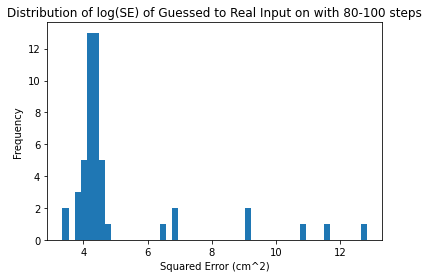

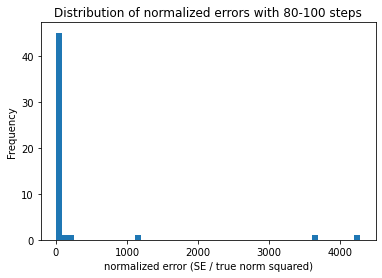

Note that the number of optimization steps is measured in terms of the number of times the closure function is called in the LBFGS optimizer


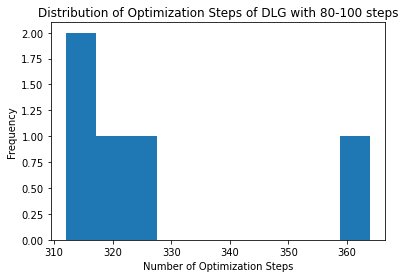

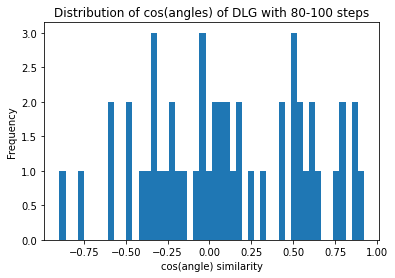

In [115]:
graph_results(errors, optimization_steps, cos_angles, n_errors)

In [ ]:
# Todo
# try to train a good model and then check if it makes a difference of attackability of input data
# consider baseline feature set to the dlg model
# see whether dlg is possible on model that is being updated